In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

sns.set_theme(style="whitegrid")

In [3]:
df = pd.read_csv('../data/processed/housing_clean.csv')

X = df.drop(columns=['price'])
y = df['price']

In [5]:
#tarnsformation logaritmique
y_log = np.log1p(y)

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200],      # arbres a creer
    'learning_rate': [0.05, 0.1],   # vitesst d'apprensisage, c'est mieux lent
    'max_depth': [3, 5],              # Profondité arbre (3-5 pour evitar memoriser)
    'num_leaves': [10, 20],           # Feuille max (moins feuilles  = model plus simple)
    'min_child_samples': [10, 20]     # Mín demaison par feuille (eviter petits groups)
}

lgb_estimator = lgb.LGBMRegressor(random_state=42, verbose=-1)

# Validation croisée à 5 plis (KFold) pour garantir le résultat
cv = KFold(n_splits=5, shuffle=True, random_state=42) 

grid_search = GridSearchCV(estimator=lgb_estimator, 
                           param_grid=param_grid, 
                           cv=cv, 
                           scoring='neg_mean_absolute_error', # chercehr l'errer plus petite
                           n_jobs=1, # utiliser otus les coeur du CPU
                           verbose=1)

print("En train de chercher le réglage plus adequate)...")
grid_search.fit(X_train, y_train_log)

En train de chercher le réglage plus adequate)...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


,estimator,"LGBMRegressor...2, verbose=-1)"
,param_grid,"{'learning_rate': [0.05, 0.1], 'max_depth': [3, 5], 'min_child_samples': [10, 20], 'n_estimators': [100, 200], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [6]:
best_model = grid_search.best_estimator_
print(f"\n The bests Hiperparámetres trouves: {grid_search.best_params_}")


 The bests Hiperparámetres trouves: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 10}


In [7]:
# Preddic du log
y_pred_log = best_model.predict(X_test)

In [8]:
# Nous revenons aux dollars réels pour mesurer l'erreur réelle.
y_pred_final = np.expm1(y_pred_log)
y_test_final = np.expm1(y_test_log)

In [9]:
#metriques
mae = mean_absolute_error(y_test_final, y_pred_final)
r2 = r2_score(y_test_final, y_pred_final)

print(f"Nouvelle MAE : ${mae:,.2f}")
print(f"Nouvelle R2 Score (Precision): {r2:.4f}")

Nouvelle MAE : $11,707.48
Nouvelle R2 Score (Precision): 0.6301


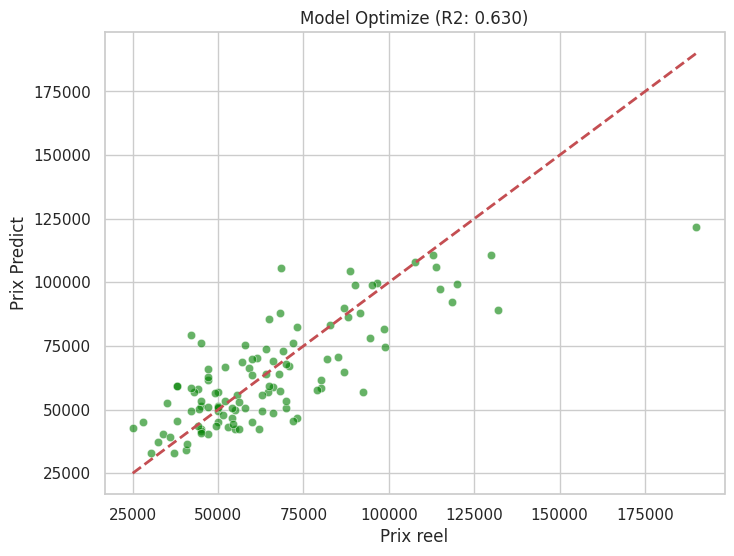

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_final, y=y_pred_final, alpha=0.6, color='green')
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
plt.title(f"Model Optimize (R2: {r2:.3f})")
plt.xlabel("Prix reel")
plt.ylabel("Prix Predict")
plt.show()

In [12]:
joblib.dump(best_model, '../models/lightgbm_optimized_v2.pkl')
print("Model Optimice 'lightgbm_optimized_v2.pkl'")

Model Optimice 'lightgbm_optimized_v2.pkl'


**Résultat numérique**

Nous avons constaté une amélioration :

- R² précédent : ~0,6118
- Nouveau R² : 0,6301
- MAE (Erreur absolue moyenne) : réduite à 11 707 $

C'est une nette amélioration (+2 %). En science des données, gagner 2 points de pourcentage simplement en ajustant certains paramètres (sans acquérir de nouvelles données) est une réussite. 
Nous avons extrait le maximum d'informations de ces 546 lignes.